In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
from scipy.signal import find_peaks
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [2]:
folder_path = user_path + '/PHYS469/saturation_spectroscopy/raw_data/10-31-2024/'
raw_probe_pump_data = {}
raw_probe_data = {}

for file_name in os.listdir(folder_path):
    file_name = file_name.strip()
    # Read the lines of the file
    with open(folder_path+file_name, 'r') as f:
        lines = f.readlines()
    # Find end of the header (the line that starts with 'x ys')
    for i, line in enumerate(lines):
        if line.startswith('x	y'):
            lines_to_skip = i
            break

    # Read data (skip header)
    data = np.genfromtxt(folder_path+file_name, skip_header=lines_to_skip, names=True, missing_values='_', filling_values=0)
    reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

    # Make a dict for the run
    file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
    # Add dict to data dict
    if 'run' in file_name:
        raw_probe_pump_data[file_name[:-4]] = file_dict
    else:
        raw_probe_data[file_name[:-4]] = file_dict

### Raw Data

In [3]:
raw_probe_pump_data.keys(), raw_probe_data.keys(), raw_probe_pump_data['run1'].keys()

(dict_keys(['run20', 'run9', 'run8', 'run19', 'run18', 'run6', 'run15', 'run14', 'run7', 'run5', 'run16', 'run17', 'run4', 'run13', 'run12', 'run1', 'run3', 'run10', 'run11', 'run2']),
 dict_keys(['nopump17', 'nopump16', 'nopump14', 'nopump15', 'nopump11', 'nopump10', 'nopump12', 'nopump13', 'nopump2', 'nopump3', 'nopump1', 'nopump4', 'nopump5', 'nopump7', 'nopump6', 'nopump8', 'nopump9', 'nopump20', 'nopump18', 'nopump19']),
 dict_keys(['x', 'y2', 'y3']))

Averaging the data for the runs

In [4]:
time = raw_probe_pump_data['run1']['x']
avg_probe_pump = np.mean([raw_probe_pump_data[run]['y2'] for run in raw_probe_pump_data.keys()], axis=0)
avg_probe = np.mean([raw_probe_data[run]['y2'] for run in raw_probe_data.keys() if run[:-1]=='nopump'], axis=0)

# make a single interferometer data array
raw_inter1 = np.array([raw_probe_data[run]['y3'] for run in raw_probe_data.keys()])
raw_inter2 = np.array([raw_probe_pump_data[run]['y3'] for run in raw_probe_pump_data.keys()])
raw_inter = np.concatenate((raw_inter1, raw_inter2), axis=0)
avg_inter = np.mean([run for run in raw_inter], axis=0)

Plot the raw data

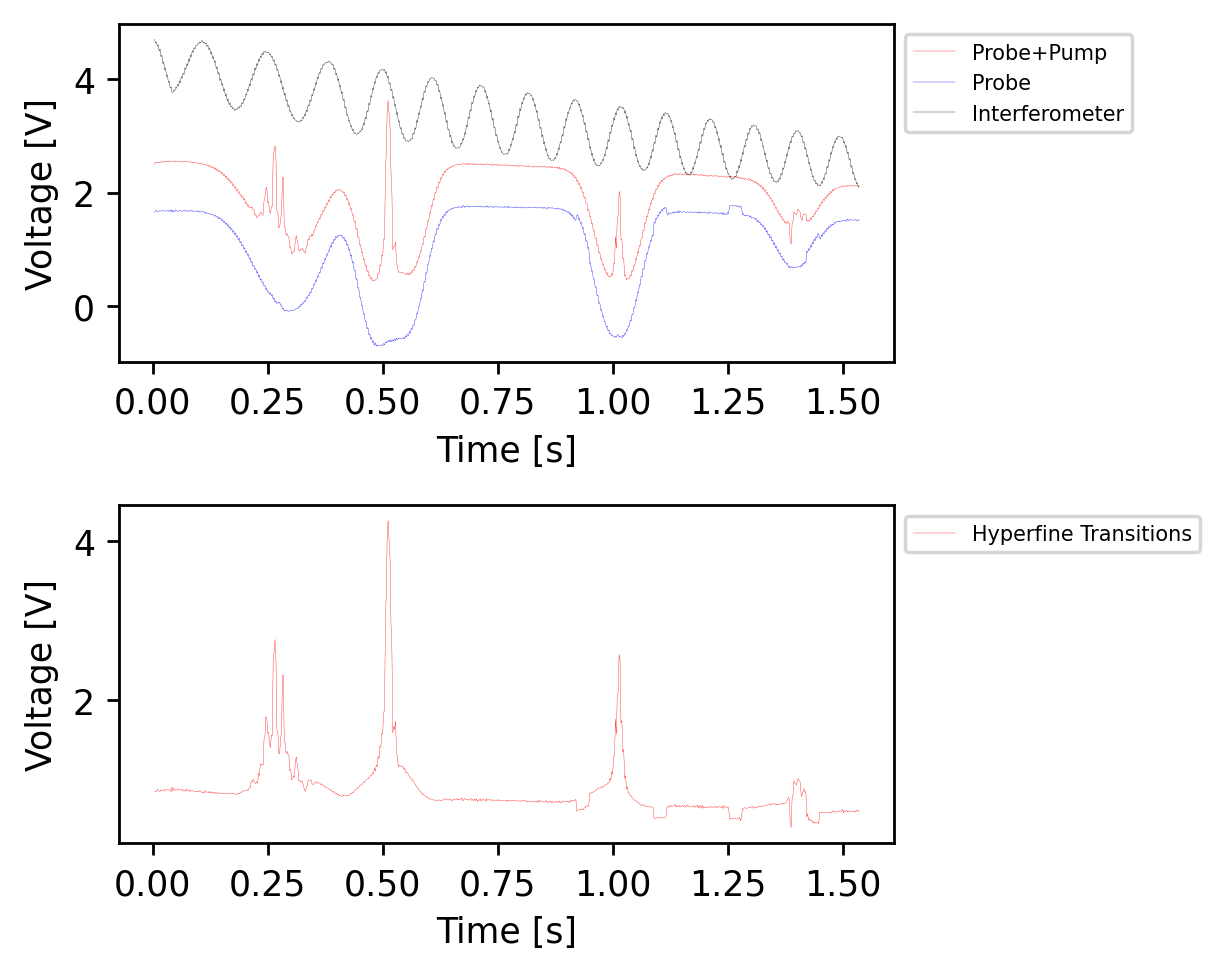

In [5]:
# Figure
fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=250)

# Get a single frequency sweep
start = np.argwhere(avg_inter == np.max(avg_inter))[0][0]
stop = np.argwhere(avg_inter == np.min(avg_inter))[0][0]
time_multiplier = 1e1
time_axis = time[start:stop]*time_multiplier

# Plot data
axes[0].plot(time_axis, avg_probe_pump[start:stop], color='r', linewidth=0.1, label = 'Probe+Pump')
axes[0].plot(time_axis, avg_probe[start:stop], color='b', linewidth=0.1, label='Probe')
axes[0].plot(time_axis, avg_inter[start:stop], color='k', linewidth=0.1, label='Interferometer')
axes[1].plot(time_axis, (avg_probe_pump-avg_probe)[start:stop], color='r', linewidth=0.1, label = 'Hyperfine Transitions')

for ax in axes:
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Voltage [V]')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout()
plt.show()


From our discussions, won't use the above data since averaging out everything smoothes too many of the features

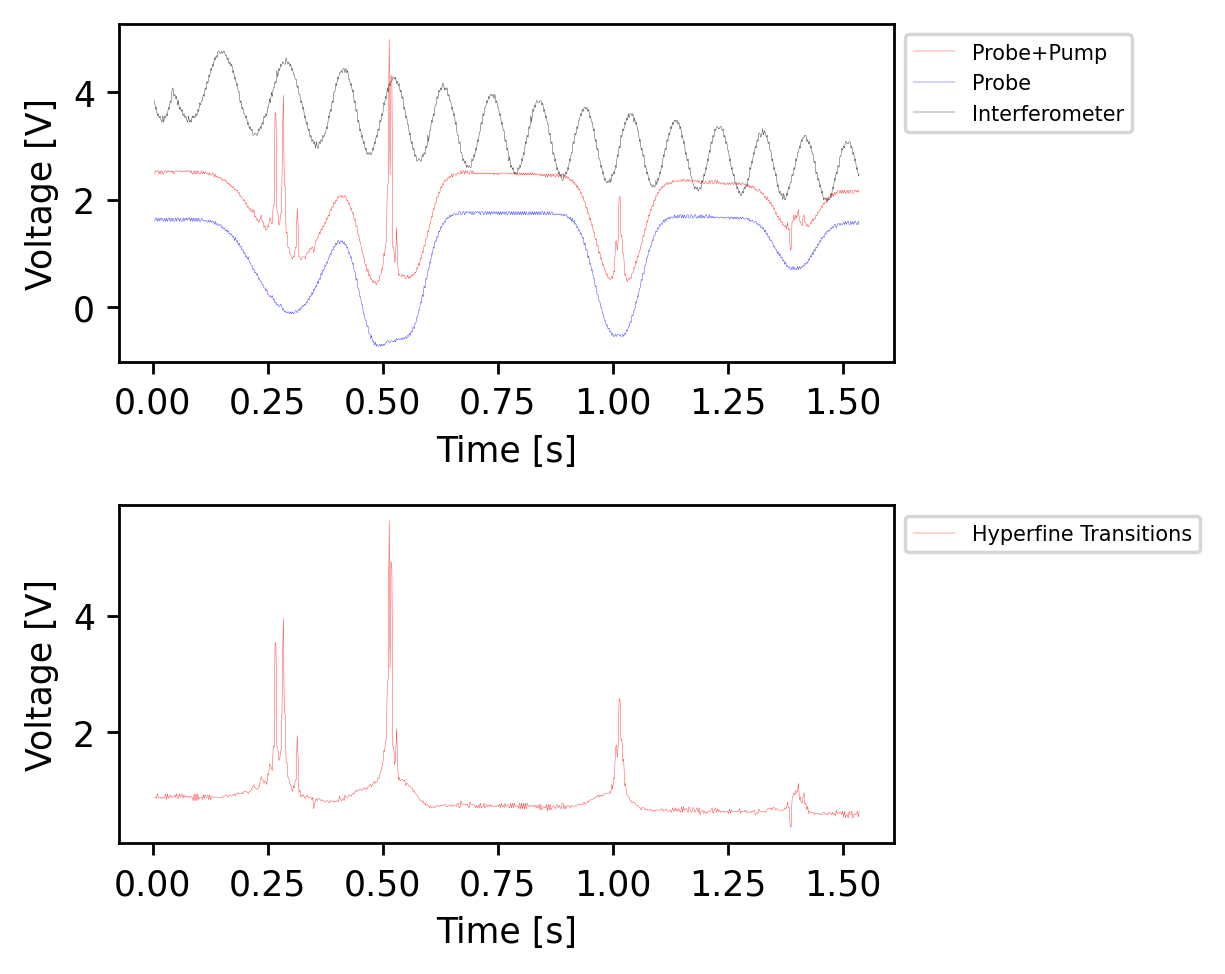

In [6]:
# Figure
fig, axes = plt.subplots(2, 1, figsize=(5,4), dpi=250)

# Get a single frequency sweep
start = np.argwhere(avg_inter == np.max(avg_inter))[0][0]
stop = np.argwhere(avg_inter == np.min(avg_inter))[0][0]
time_multiplier = 1e1
time_axis = time[start:stop]*time_multiplier
probe_run = raw_probe_data['nopump1']['y2']
probe_pump_run = raw_probe_pump_data['run1']['y2']
inter_run = raw_probe_pump_data['run1']['y3']


# Plot data
axes[0].plot(time_axis, probe_pump_run[start:stop], color='r', linewidth=0.1, label = 'Probe+Pump')
axes[0].plot(time_axis, probe_run[start:stop], color='b', linewidth=0.1, label='Probe')
axes[0].plot(time_axis, inter_run[start:stop], color='k', linewidth=0.1, label='Interferometer')
axes[1].plot(time_axis, (probe_pump_run-probe_run)[start:stop], color='r', linewidth=0.1, label = 'Hyperfine Transitions')

for ax in axes:
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Voltage [V]')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout()
plt.show()


## Interferometer

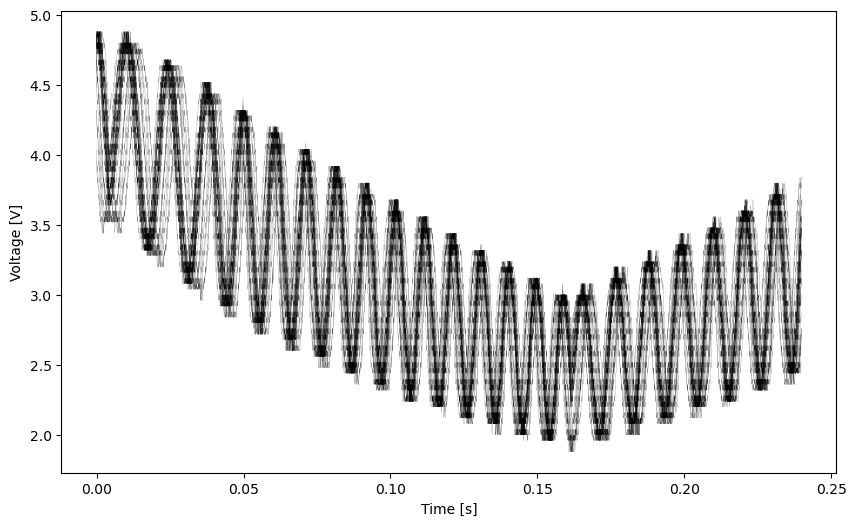

In [9]:
# plot all interferometer runs on one plot
plt.figure(figsize = (10, 6))
for run in raw_inter:
    plt.plot(time, run, color='k', linewidth=0.1)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.show()


This isn't super matched up, so we'll get the frequency location for each run and then average at the end.

In [234]:
def find_local_maxima_inter(data):
    local_maxima = []
    for i in range(1, len(data) - 2):
        # check that its a local maxima
        if data[i] > data[i - 2] and data[i] > data[i + 2]:
            # check that another maxima wasn't found within 5 indices
            if len(local_maxima) == 0 or i - local_maxima[-1] > 5:
                local_maxima.append(i)
    return local_maxima

def find_local_maxima_hyper(data):
    local_maxima = []
    for i in range(1, len(data) - 2):
        # check that its a local maxima
        if data[i] > data[i - 2] and data[i] > data[i + 2]:
            # check that another maxima wasn't found within 5 indices
            local_maxima.append(i)
    return local_maxima

In [391]:
# FINDING THE HYPERFINE PEAK INDICES BY HAND FOR EACH RUN :(
hyperfine_peaks = {
    'run1':    [133, 142, 157,    257, 259, 265,    503, 507, 512,    697, 702, 708], 
    'run2':     [133, 142, 157,    257, 259, 265,    503, 507, 512,    697, 702, 708],
    'run3':     [133, 142, 157,    257, 259, 264,    503, 507, 512,    697, 702, 708],
    'run4':     [133, 142, 157,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run5':     [133, 142, 156,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run6':     [133, 142, 156,    256, 259, 264,    503, 507, 512,    697, 702, 708],
    'run7':     [132, 141, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run8':     [132, 141, 156,    256, 259, 264,    503, 507, 512,    696, 702, 708],
    'run9':     [132, 141, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run10':    [132, 140, 156,    256, 258, 264,    503, 507, 512,    696, 702, 708],
    'run11':    [126, 135, 150,    255, 258, 263,    503, 507, 512,    698, 703, 709],
    # 'run12': [],
    # 'run13': [],
    # 'run14': [],
    # 'run15': [],
    # 'run16': [],
    # 'run17': [],
    # 'run18': [],
    # 'run19': [],
    # 'run20': [],
}


Section for manually finding peaks below

[2, 5, 7, 9, 14, 16, 19, 21, 26, 29, 34, 37, 39, 41, 43, 45, 47, 49, 52, 55, 57, 60, 62, 64, 72, 80, 84, 89, 93, 101, 106, 110, 115, 117, 119, 123, 125, 131, 134, 138, 140, 142, 145, 147, 149, 154, 157, 162, 164, 166, 174, 176, 178, 181, 184, 186, 198, 200, 202, 206, 214, 217, 221, 226, 232, 237, 239, 241, 243, 245, 255, 257, 263, 266, 269, 272, 274, 276, 280, 284, 294, 296, 299, 301, 307, 310, 313, 322, 324, 330, 335, 339, 342, 345, 347, 349, 352, 356, 358, 360, 363, 365, 367, 369, 371, 374, 376, 379, 383, 386, 389, 391, 393, 395, 397, 399, 401, 403, 405, 408, 410, 412, 414, 416, 418, 420, 422, 425, 428, 430, 432, 435, 437, 440, 442, 446, 448, 451, 453, 455, 457, 461, 466, 469, 471, 473, 475, 480, 484, 493, 495, 497, 499, 501, 503, 507, 510, 512, 514, 516, 520, 526, 532, 534, 537, 539, 541, 547, 549, 554, 556, 558, 560, 563, 565, 570, 572, 575, 577, 580, 584, 588, 594, 596, 598, 600, 603, 606, 608, 611, 620, 622, 624, 626, 628, 631, 633, 635, 638, 640, 642, 644, 647, 650, 654, 657, 66

(50.0, 800.0)

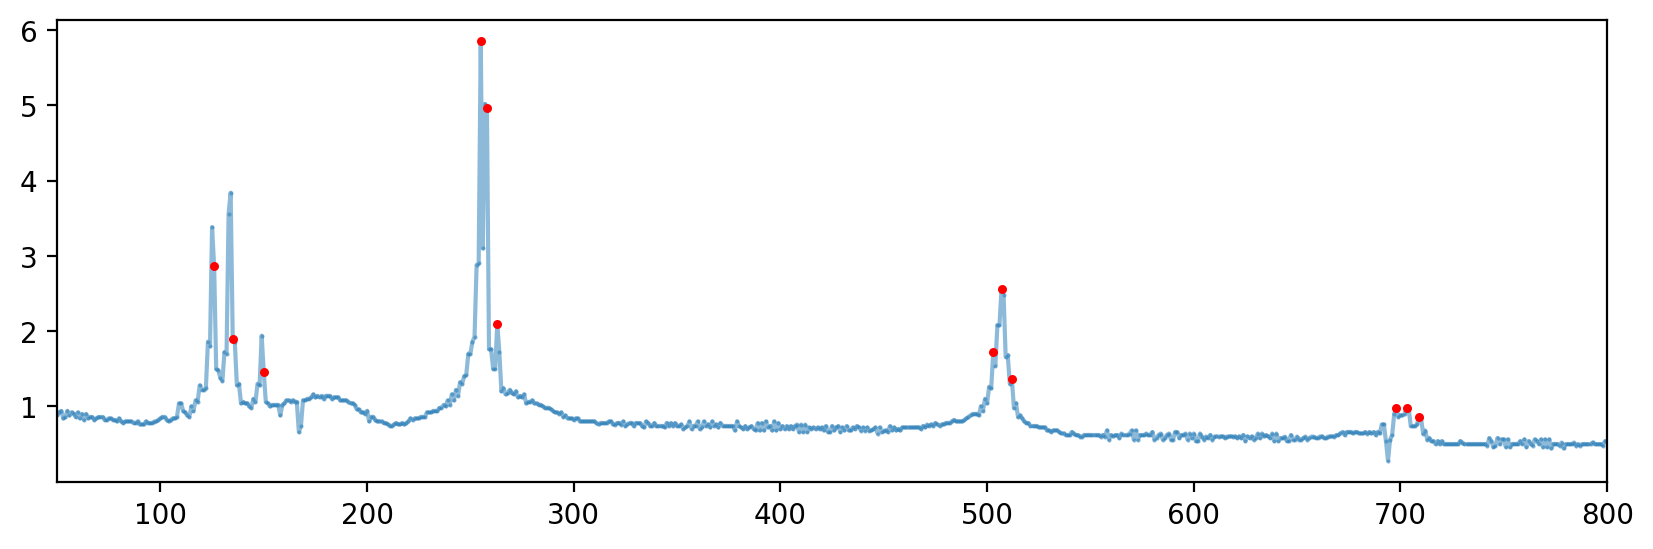

In [363]:
def find_local_maxima_hyper(data):
    local_maxima = []
    for i in range(1, len(data) - 1):
        # check that its a local maxima
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            # check that another maxima wasn't found within 5 indices
            local_maxima.append(i)
    return local_maxima

i = 12
# loading run
probe_data = raw_probe_pump_data['run'+str(i)]['y2'] - raw_probe_data['nopump1']['y2']
rough_peaks = find_local_maxima_hyper(probe_data)
print(rough_peaks)

plt.figure(figsize = (10, 3), dpi = 200)
plt.plot(np.arange(len(probe_data)), probe_data, zorder = 0, marker = '.', markersize = 1, alpha = 0.5)
# plot location of peaks
# plt.scatter(rough_peaks, probe_data[rough_peaks], color='r', s = 10)

# choosing indices of peaks
indices = [126, 135, 150,    255, 258, 263,    503, 507, 512,    698, 703, 709]

# plotting these points from the original data
plt.scatter(indices, probe_data[indices], color='r', s = 5)

plt.xlim(50, 800)
# plt.xlim(100, 200)
# plt.xlim(200, 300)
# plt.xlim(475, 575)
# plt.xlim(600, 800)

In [400]:
freq_gaps = {}

for i in range(1, 11):

    # load hyperfine peaks
    hyperfine_peaks_time = hyperfine_peaks['run'+str(i)]

    # load interferometer data and find peaks in it
    inter_data = raw_probe_pump_data['run'+str(i)]['y3']
    inter_peaks = find_local_maxima_inter(inter_data)

    # load the time
    time = raw_probe_pump_data['run'+str(i)]['x']

    # find the time intervals between the peaks
    time_intervals = np.diff(time[inter_peaks])

    # convert to frequency space using delta_f = c / (2 * delta_L * time_intervals)
    c = 3e8 # m/s
    delta_L = 0.34 # meters
    frequencies = c / (2 * delta_L * time_intervals)

    # build frequency scale for this run
    frequency_scale = np.cumsum(np.insert(frequencies, 0, 0))

    # interpolate the probe + pump data to the frequency scale
    time_to_frequency = interp1d(time[inter_peaks], frequency_scale, kind='linear', fill_value="extrapolate")

    # Apply the mapping to get frequency positions of hyperfine peaks
    hyperfine_frequencies = time_to_frequency(time[hyperfine_peaks_time])

    # get the difference between the peaks
    difference = np.diff(hyperfine_frequencies)

    freq_gaps['run_'+str(i)] = difference

In [401]:
freq_gaps

{'run_1': array([2.01142440e+10, 7.59601361e+09, 6.31438169e+10, 1.51295086e+09,
        1.27674527e+10, 2.89137162e+11, 9.18734841e+08, 1.14841855e+09,
        4.60650008e+11, 5.96506856e+09, 7.15808227e+09]),
 'run_2': array([4.93762021e+09, 7.37095908e+09, 6.35405187e+10, 1.57058195e+09,
        1.28250838e+10, 2.24553773e+11, 9.57414216e+08, 1.19676777e+09,
        1.38823009e+11, 4.24045051e+09, 5.08854061e+09]),
 'run_3': array([7.38703230e+09, 2.41696386e+10, 1.52048077e+11, 1.18563953e+09,
        3.41002909e+09, 3.28604943e+11, 4.35729847e+09, 5.44662309e+09,
        3.11823972e+11, 5.21238741e+09, 6.54563857e+09]),
 'run_4': array([1.03255384e+10, 8.07818244e+09, 6.53021505e+10, 2.26942629e+09,
        3.78237715e+09, 1.99086517e+11, 3.52941176e+09, 4.41176471e+09,
        2.14532702e+11, 4.24045051e+09, 1.33963620e+10]),
 'run_5': array([2.34271648e+11, 3.21356430e+10, 1.47290696e+11, 7.35294118e+09,
        1.22549020e+10, 3.11282965e+11, 3.52941176e+09, 4.31470274e+09,
   

Taking the average of the gaps across all the runs
Note: we're ignoring every 3rd data point here, since it's the gaps between the doppler broadened peaks themselves, which we don't care about.

<ErrorbarContainer object of 3 artists>

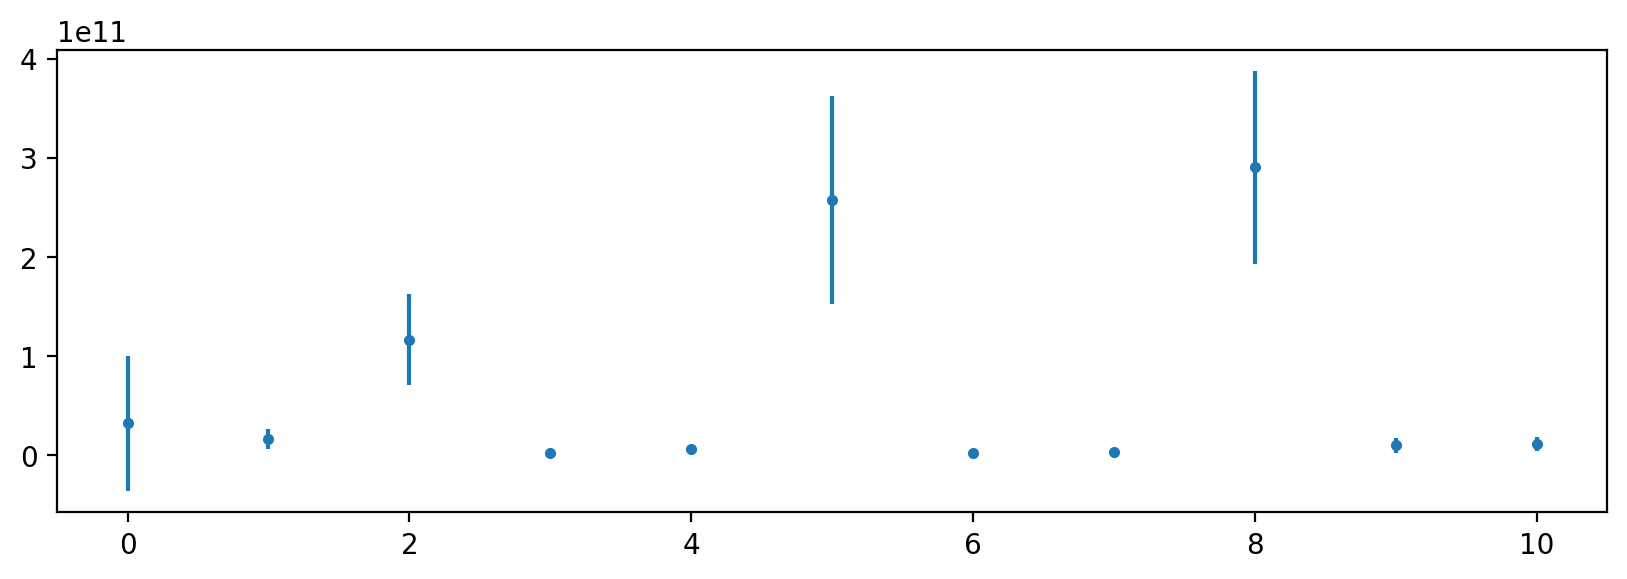

In [404]:
# taking the average across all runs
average_freq_gaps = np.mean([freq_gaps['run_'+str(i)] for i in range(1, 11)], axis = 0)

# getting the standard deviation
std_freq_gaps = np.std([freq_gaps['run_'+str(i)] for i in range(1, 11)], axis = 0)

# plotting the average frequency gaps
plt.figure(figsize = (10, 3), dpi = 200)
plt.errorbar(np.arange(len(average_freq_gaps)), average_freq_gaps, yerr = std_freq_gaps, fmt = 'o', markersize = 3)

In [419]:
good_seps = [0, 1, 3, 4, 6, 7, 9, 10]
print('Results: ', average_freq_gaps[good_seps] * 1e-9, 'GHz')
print('Standard Deviation: ', std_freq_gaps[good_seps] * 1e-9, 'GHz')

Results:  [31.7785671  16.07975372  2.224139    6.48388589  2.22297789  2.71727324
  9.56423798 11.11230951] GHz
Standard Deviation:  [67.6910371  10.2829308   1.73888071  4.04778796  1.35447718  1.62365959
  7.46478456  7.15811685] GHz
